In [1]:
import tensorflow as tf
import numpy as np
tf.set_random_seed(777)  # reproducibility

idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hello: hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3

y_data = [[1, 0, 2, 3, 3, 4]]    # ihello

num_classes = 5
input_dim = 5  # one-hot size
hidden_size = 5  # output from the LSTM. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 6  # |ihello| == 6
learning_rate = 0.1

X = tf.placeholder(
    tf.float32, [None, sequence_length, input_dim])  # X one-hot
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(
    cell, X, initial_state=initial_state, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b
outputs = tf.contrib.layers.fully_connected(
    inputs=X_for_fc, num_outputs=num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        l, _ = sess.run([loss, train], feed_dict={X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_one_hot})
        print(i, "loss:", l, "prediction: ", result, "true Y: ", y_data)

        # print char using dic
        result_str = [idx2char[c] for c in np.squeeze(result)]
        print("\tPrediction str: ", ''.join(result_str))

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
0 loss: 1.6078763 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
1 loss: 1.5102623 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
2 loss: 1.4327028 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
3 loss: 1.3489527 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
4 loss: 1.2551297 prediction:  [[1 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  illlll
5 loss: 1.140437 prediction:  [[1 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  illlll
6 loss: 1.0167553 prediction:  [[1 3 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ilello
7 loss: 0.8969264 prediction:  [[1 3 2 3 3 4]] true Y: 

# 한문장

In [4]:
tf.reset_default_graph()
sample = " if you want you"
idx2char = list(set(sample))  # index -> char
char2idx = {c: i for i, c in enumerate(idx2char)}  # char -> idex

# hyper parameters
dic_size = len(char2idx)  # RNN input size (one hot size)
hidden_size = len(char2idx)  # RNN output size
num_classes = len(char2idx)  # final output size (RNN or softmax, etc.)
batch_size = 1  # one sample data, one batch
sequence_length = len(sample) - 1  # number of lstm rollings (unit #)
learning_rate = 0.1

sample_idx = [char2idx[c] for c in sample]  # char to index
x_data = [sample_idx[:-1]]  # X data sample (0 ~ n-1) hello: hell
y_data = [sample_idx[1:]]   # Y label sample (1 ~ n) hello: ello

X = tf.placeholder(tf.int32, [None, sequence_length])  # X data
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label

x_one_hot = tf.one_hot(X, num_classes)  # one hot: 1 -> 0 1 0 0 0 0 0 0 0 0
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=initial_state, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        l, _ = sess.run([loss, train], feed_dict={X: x_data, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_data})

        # print char using dic
        result_str = [idx2char[c] for c in np.squeeze(result)]

        print(i, "loss:", l, "Prediction:", ''.join(result_str))


0 loss: 2.315674 Prediction: y              
1 loss: 2.1732354 Prediction: y    u        u
2 loss: 2.0825799 Prediction: y    u        u
3 loss: 1.9638798 Prediction: y  y u y y  y u
4 loss: 1.7909534 Prediction: y  y u yayt you
5 loss: 1.5607792 Prediction: y  you yayt you
6 loss: 1.2799433 Prediction: y  you yayt you
7 loss: 1.0100571 Prediction: y  you uaat you
8 loss: 0.7785228 Prediction: y  you want you
9 loss: 0.5790045 Prediction: if you want you
10 loss: 0.4213331 Prediction: if you want you
11 loss: 0.2973382 Prediction: if you want you
12 loss: 0.2039812 Prediction: if you want you
13 loss: 0.13969587 Prediction: if you want you
14 loss: 0.09529519 Prediction: if you want you
15 loss: 0.06479823 Prediction: if you want you
16 loss: 0.044400793 Prediction: if you want you
17 loss: 0.031073388 Prediction: if you want you
18 loss: 0.022403993 Prediction: if you want you
19 loss: 0.016653137 Prediction: if you want you
20 loss: 0.012670273 Prediction: if you want you
21 loss: 0.

# 긴문장

In [15]:
from __future__ import print_function
from tensorflow.contrib import rnn
tf.reset_default_graph()

sentence = (" if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

char_set = list(set(sentence))
char_dic = {w: i for i, w in enumerate(char_set)}

data_dim = len(char_set)
hidden_size = len(char_set)
num_classes = len(char_set)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

dataX = []
dataY = []
for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
#    print(i, x_str, '->', y_str)

    x = [char_dic[c] for c in x_str]  # x str to index
    y = [char_dic[c] for c in y_str]  # y str to index

    dataX.append(x)
    dataY.append(y)

batch_size = len(dataX)

X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])

# One-hot encoding
X_one_hot = tf.one_hot(X, num_classes)
#print(X_one_hot)  # check out the shape


# Make a lstm cell with hidden_size (each unit output vector size)
def lstm_cell():
    cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
    return cell

multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(2)], state_is_tuple=True)

# outputs: unfolding size x hidden size, state = hidden size
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

# All weights are 1 (equal weights)
weights = tf.ones([batch_size, sequence_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
mean_loss = tf.reduce_mean(sequence_loss)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    _, l, results = sess.run(
        [train_op, mean_loss, outputs], feed_dict={X: dataX, Y: dataY})
    for j, result in enumerate(results):
        index = np.argmax(result, axis=1)
#        print(i, j, ''.join([char_set[t] for t in index]), l)

# Let's print the last char of each result to check it works
results = sess.run(outputs, feed_dict={X: dataX})
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0:  # print all for the first result to make a sentence
        print(''.join([char_set[t] for t in index]), end='')
    else:
        print(char_set[index[-1]], end='')
print("\n")
print(sentence)

tf you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.

 if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.


# 주식데이터

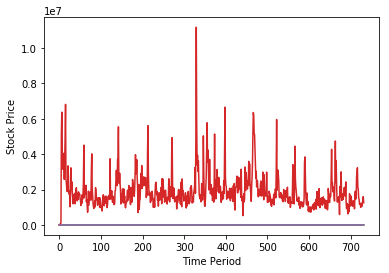

In [26]:
plt.plot(xy)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

Populating the interactive namespace from numpy and matplotlib
[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.741138

C:\Users\Song\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  # Remove the CWD from sys.path while we load stuff.


[[0.09484332 0.13002817 0.11792231 0.16701622 0.14370895]
 [0.1325874  0.13730964 0.13603665 0.15275612 0.11797353]
 [0.114371   0.12910937 0.14154965 0.14366765 0.12600055]
 [0.09957004 0.11066715 0.11133528 0.17805862 0.09192159]
 [0.09691349 0.09229303 0.09203955 0.25145648 0.07481176]
 [0.05834126 0.05809648 0.0051551  0.35460249 0.00999833]
 [0.00810774 0.03751064 0.03311417 0.25770368 0.0434436 ]] -> [0.06530621]
[[0.1325874  0.13730964 0.13603665 0.15275612 0.11797353]
 [0.114371   0.12910937 0.14154965 0.14366765 0.12600055]
 [0.09957004 0.11066715 0.11133528 0.17805862 0.09192159]
 [0.09691349 0.09229303 0.09203955 0.25145648 0.07481176]
 [0.05834126 0.05809648 0.0051551  0.35460249 0.00999833]
 [0.00810774 0.03751064 0.03311417 0.25770368 0.0434436 ]
 [0.06313692 0.06088662 0.0613597  0.26161154 0.06530621]] -> [0.08378899]
[[0.114371   0.12910937 0.14154965 0.14366765 0.12600055]
 [0.09957004 0.11066715 0.11133528 0.17805862 0.09192159]
 [0.09691349 0.09229303 0.09203955 0.2

 [0.57484585 0.57045414 0.54929116 0.27078964 0.534163  ]] -> [0.4612174]
[[0.2431199  0.28820734 0.27721916 0.42667384 0.30733474]
 [0.53251321 0.60733171 0.56361074 1.         0.6350262 ]
 [0.56784207 0.58831786 0.59228573 0.52460339 0.60013779]
 [0.55393833 0.60233661 0.59690372 0.30198978 0.59760289]
 [0.5735348  0.6215274  0.61372927 0.35147441 0.59689874]
 [0.57484585 0.57045414 0.54929116 0.27078964 0.534163  ]
 [0.52561304 0.51784967 0.48313478 0.32426279 0.4612174 ]] -> [0.47424342]
[[0.53251321 0.60733171 0.56361074 1.         0.6350262 ]
 [0.56784207 0.58831786 0.59228573 0.52460339 0.60013779]
 [0.55393833 0.60233661 0.59690372 0.30198978 0.59760289]
 [0.5735348  0.6215274  0.61372927 0.35147441 0.59689874]
 [0.57484585 0.57045414 0.54929116 0.27078964 0.534163  ]
 [0.52561304 0.51784967 0.48313478 0.32426279 0.4612174 ]
 [0.43591077 0.47065544 0.47590332 0.23908757 0.47424342]] -> [0.47684858]
[[0.56784207 0.58831786 0.59228573 0.52460339 0.60013779]
 [0.55393833 0.6023366

 [0.8690003  0.89128647 0.91444043 0.19757999 0.9295893 ]] -> [0.92740658]
[[0.80910663 0.80019865 0.82039652 0.18531863 0.7901762 ]
 [0.76228892 0.7945502  0.80106522 0.17011742 0.83228187]
 [0.80952062 0.80256329 0.84293911 0.13471363 0.8193966 ]
 [0.80362111 0.83510929 0.85716211 0.15025545 0.8711485 ]
 [0.84212398 0.83711692 0.89450039 0.11823967 0.86555076]
 [0.8690003  0.89128647 0.91444043 0.19757999 0.9295893 ]
 [0.90667519 0.90757826 0.94601513 0.12607332 0.92740658]] -> [0.90029864]
[[0.76228892 0.7945502  0.80106522 0.17011742 0.83228187]
 [0.80952062 0.80256329 0.84293911 0.13471363 0.8193966 ]
 [0.80362111 0.83510929 0.85716211 0.15025545 0.8711485 ]
 [0.84212398 0.83711692 0.89450039 0.11823967 0.86555076]
 [0.8690003  0.89128647 0.91444043 0.19757999 0.9295893 ]
 [0.90667519 0.90757826 0.94601513 0.12607332 0.92740658]
 [0.88787217 0.8823002  0.89521641 0.20840728 0.90029864]] -> [0.89984095]
[[0.80952062 0.80256329 0.84293911 0.13471363 0.8193966 ]
 [0.80362111 0.835109

 [0.22570604 0.21526681 0.15247254 0.52487001 0.14013479]] -> [0.15202208]
[[0.29056994 0.31588576 0.3219682  0.11748262 0.30553713]
 [0.27282543 0.31323317 0.32245296 0.12540301 0.29926518]
 [0.27264541 0.29572635 0.30191562 0.1341993  0.29872778]
 [0.28775254 0.2987326  0.32729943 0.11712853 0.30261025]
 [0.26323346 0.26142075 0.24218202 0.26025457 0.2514783 ]
 [0.22570604 0.21526681 0.15247254 0.52487001 0.14013479]
 [0.16647695 0.1778956  0.18250869 0.27889077 0.15202208]] -> [0.16534255]
[[0.27282543 0.31323317 0.32245296 0.12540301 0.29926518]
 [0.27264541 0.29572635 0.30191562 0.1341993  0.29872778]
 [0.28775254 0.2987326  0.32729943 0.11712853 0.30261025]
 [0.26323346 0.26142075 0.24218202 0.26025457 0.2514783 ]
 [0.22570604 0.21526681 0.15247254 0.52487001 0.14013479]
 [0.16647695 0.1778956  0.18250869 0.27889077 0.15202208]
 [0.16425888 0.17960523 0.17402746 0.16392404 0.16534255]] -> [0.17442218]
[[0.27264541 0.29572635 0.30191562 0.1341993  0.29872778]
 [0.28775254 0.298732

 [0.88723699 0.88829938 0.92518158 0.08714288 0.90908564]] -> [0.90030461]
[[0.79725431 0.81461829 0.83903438 0.12098623 0.8285645 ]
 [0.81529885 0.82251706 0.84757626 0.1060959  0.83698714]
 [0.83034597 0.81556125 0.85575466 0.07523435 0.84403567]
 [0.84347469 0.8426171  0.88749985 0.10121322 0.86858608]
 [0.86925245 0.87626864 0.92209184 0.1140722  0.90185774]
 [0.88723699 0.88829938 0.92518158 0.08714288 0.90908564]
 [0.88939504 0.88829938 0.94014512 0.13380794 0.90030461]] -> [0.93124657]
[[0.81529885 0.82251706 0.84757626 0.1060959  0.83698714]
 [0.83034597 0.81556125 0.85575466 0.07523435 0.84403567]
 [0.84347469 0.8426171  0.88749985 0.10121322 0.86858608]
 [0.86925245 0.87626864 0.92209184 0.1140722  0.90185774]
 [0.88723699 0.88829938 0.92518158 0.08714288 0.90908564]
 [0.88939504 0.88829938 0.94014512 0.13380794 0.90030461]
 [0.89281215 0.89655181 0.94323484 0.12965206 0.93124657]] -> [0.95460261]
[[0.83034597 0.81556125 0.85575466 0.07523435 0.84403567]
 [0.84347469 0.842617

[step: 197] loss: 0.8944171667098999
[step: 198] loss: 0.8919219970703125
[step: 199] loss: 0.8894100785255432
[step: 200] loss: 0.8868805766105652
[step: 201] loss: 0.8843339681625366
[step: 202] loss: 0.8817694783210754
[step: 203] loss: 0.8791871666908264
[step: 204] loss: 0.8765869140625
[step: 205] loss: 0.8739686012268066
[step: 206] loss: 0.8713324666023254
[step: 207] loss: 0.8686784505844116
[step: 208] loss: 0.86600661277771
[step: 209] loss: 0.8633177876472473
[step: 210] loss: 0.860611617565155
[step: 211] loss: 0.8578885197639465
[step: 212] loss: 0.8551488518714905
[step: 213] loss: 0.8523933291435242
[step: 214] loss: 0.8496220707893372
[step: 215] loss: 0.8468359112739563
[step: 216] loss: 0.8440355062484741
[step: 217] loss: 0.8412209749221802
[step: 218] loss: 0.8383935689926147
[step: 219] loss: 0.8355540037155151
[step: 220] loss: 0.8327026963233948
[step: 221] loss: 0.8298410773277283
[step: 222] loss: 0.826969563961029
[step: 223] loss: 0.8240891695022583
[step: 2

[step: 421] loss: 0.5891391038894653
[step: 422] loss: 0.5889052152633667
[step: 423] loss: 0.5887209177017212
[step: 424] loss: 0.5886228680610657
[step: 425] loss: 0.5886656641960144
[step: 426] loss: 0.5888513922691345
[step: 427] loss: 0.5890305638313293
[step: 428] loss: 0.5887575745582581
[step: 429] loss: 0.5878511667251587
[step: 430] loss: 0.5868368744850159
[step: 431] loss: 0.5864861607551575
[step: 432] loss: 0.586730420589447
[step: 433] loss: 0.5868388414382935
[step: 434] loss: 0.5863557457923889
[step: 435] loss: 0.5856190323829651
[step: 436] loss: 0.5852879285812378
[step: 437] loss: 0.5853772759437561
[step: 438] loss: 0.5853525996208191
[step: 439] loss: 0.5849344730377197
[step: 440] loss: 0.5844151973724365
[step: 441] loss: 0.5841884016990662
[step: 442] loss: 0.5841855406761169
[step: 443] loss: 0.5840604901313782
[step: 444] loss: 0.583699643611908
[step: 445] loss: 0.5833173394203186
[step: 446] loss: 0.5831237435340881
[step: 447] loss: 0.5830504298210144
[st

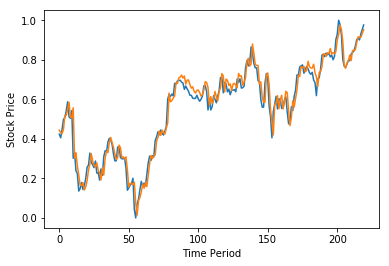

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
%pylab inline
tf.set_random_seed(777)  # reproducibility

if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

import matplotlib.pyplot as plt

tf.reset_default_graph()
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))


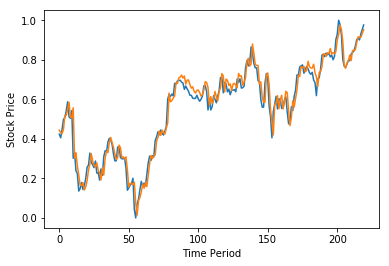

In [21]:
with tf.Session() as sess:
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()